## Testing Saved a2c

In [1]:
import time
import yaml
import gym
import os
import pandas as pd
from matplotlib import pyplot as plt
import sys

sys.modules["gym"] = gym
from stable_baselines3.common.vec_env import DummyVecEnv, VecNormalize
from stable_baselines3.common.monitor import Monitor
from building_energy_storage_simulation import Environment
import torch

from algorithms.A2C_continuous import ACAgent

In [2]:
# Load environment configuration from file
environment_config_path = os.path.join("configs", "env.yaml")
with open(environment_config_path, "r") as f:
    environment_config = yaml.safe_load(f)

# Initialize the environment with test dataset
env = Environment(dataset="test.csv", **environment_config)



In [4]:
state_dim = env.observation_space.shape[0]
action_dim = env.action_space.shape[0]

agent_ = ACAgent(state_dim, action_dim)

#load the saved agent
def load_agent(agent, filename):
    agent.actor.load_state_dict(torch.load(f'.saved_agents/{filename}_actor.pt'))
    agent.critic.load_state_dict(torch.load(f'.saved_agents/{filename}_critic.pt'))
    agent.actor.eval()
    agent.critic.eval()
    return agent
loaded_agent = load_agent(agent=agent_, filename='a2c_trained')

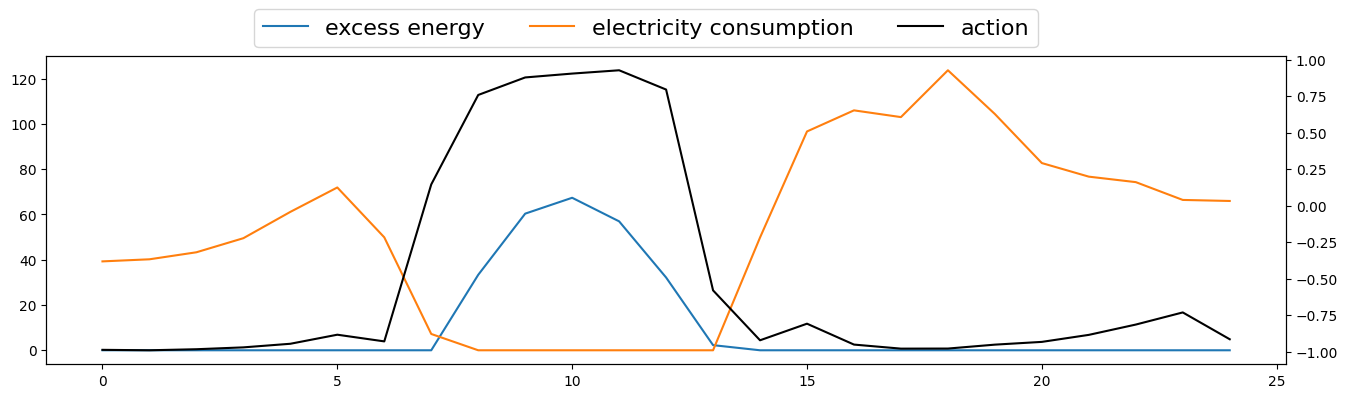

In [5]:
# Evaluate the model on the test set
env.training = False
actions, observations, electricity_consumption, excess_energy, cost_of_external_generator, rewards = ([], [], [], [], [], [])
done = False
obs = env.reset()[0]
while not done:
    action = loaded_agent.select_action(obs)
    obs, r, done,_, info = env.step(action)
    actions.append(action)
   
    observations.append(0)
    electricity_consumption.append(info['electricity_consumption'])
    excess_energy.append(info['excess_energy'])
    cost_of_external_generator.append(info['cost_of_external_generator'])
    rewards.append(r)
# Save the results to a CSV file
trajectory = pd.DataFrame({
    'action': actions,
    'electricity_consumption': electricity_consumption,
    'excess_energy': excess_energy,
    'cost_of_external_generator': cost_of_external_generator,
    'reward': rewards
})

trajectory.to_csv(os.path.join("vpg_evaluation_results","test_results.csv"), index=False)

day_number = 0
plot_data = trajectory[day_number * 24 : (day_number + 3) * 24]

plt.rcParams["figure.figsize"] = (16,4)

fig, ax = plt.subplots()


ax.plot(plot_data['excess_energy'], label = 'excess energy')
ax.plot(plot_data['electricity_consumption'], label = 'electricity consumption')

ax1 = ax.twinx()
ax1.plot(plot_data['action'], label = 'action', color = 'black')
fig.legend(bbox_to_anchor=[0.5, 0.95], loc = 'center', ncol=5, prop={'size': 16})


In [6]:

costs = []
done = False
obs = env.reset()[0]

while not done:
    action = loaded_agent.select_action(obs)
    obs, r, done,_ ,info = env.step(action)
    costs.append(info['cost_of_external_generator'])

total_costs = sum(costs)
print("Total cost of external generator: ", total_costs)


Total cost of external generator:  65572.33834092613


In [7]:

baseline_costs = []
done = False
obs = env.reset()[0]
while not done:
    # Always taking noop as action. This is the electricity demand if there would be no battery
    action = [0]
    obs, r, done,_, info = env.step(action)
    baseline_costs.append(info['cost_of_external_generator'])

baseline_total_costs = sum(baseline_costs)

print("Total cost of external generator without battery: ", baseline_total_costs)
money_saved = baseline_total_costs - total_costs
percentage_saved = money_saved / baseline_total_costs * 100
print(f'Money saved: {money_saved:2f} $')
print(f'Percentage saved: {percentage_saved:2f} %')

Total cost of external generator without battery:  69856.14039999999
Money saved: 4283.802059 $
Percentage saved: 6.132320 %
